## Time series decomposition

Geodetic time series generally contain signals from many different temporal scales. These signals can correspond to distinct physical mechanisms, so one task of interest is to decompose time series into a linear combination of signals of different temporal time scales and patterns. In `iceutils`, this is accomplished via a linear regression problem where the columns of the design matrix consist of different "basis" functions we expect to see in a given time series. For example, the design matrix can include a linear function for secular processes, sinusoidal functions for periodic processes, and one-sided splines for transient processes. When the design matrix is overcomplete or ill-posed (in a linear algebra sense), some form of coefficient regularization can be used to arrive at a unique solution.

In this tutorial, we'll make use of the `iceutils.tseries` submodule to help construct the design matrix, perform least squares, and decompose time series into different functional components.

First, let's import the necessary Python packages.

In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import iceutils as ice
import sys

First, let's create a synthetic time series consisting of a secular component (i.e., linear rate), seasonal components, and a transient displacement in the middle of the time series.

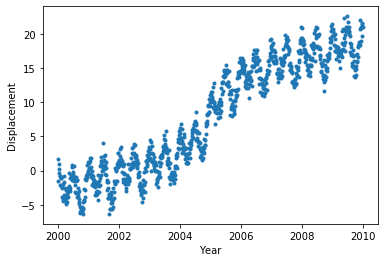

In [2]:
# First, create time vector (units of years)
Nt = 1000
t = np.linspace(2000.0, 2010.0, Nt)

# Secular signal
d_secular = -3.0 + 1.0 * (t - t[0])

# Seasonal signal (annual + semiannual)
d_seasonal = (1.0 * np.cos(2.0 * np.pi * (t - 0.25)) - 
              2.5 * np.cos(2.0 * np.pi / 0.5 * (t - 0.75)))

# Transient
d_transient = 4.0 * np.arctan((t - 2005.0) / 0.5)
d_transient -= d_transient[0]

# Total signal
d_signal = d_secular + d_seasonal + d_transient

# Add noise
noise = 1.0 * np.random.randn(Nt)
d = d_signal + noise

plt.plot(t, d, '.')
plt.xlabel('Year')
plt.ylabel('Displacement')
plt.show()

Now, let's setup the necessary functions for building a design matrix of basis functions to use in a linear regression. The first thing we need to do is to write a function that creates a Python list of basis functions. The basis functions are computed in the `ice.tseries.timefn` submodule.

In [3]:
def build_collection(dates):
    """
    Function that creates a list of basis functions for a given datetime vector dates.
    """
    # Get date bounds
    tstart, tend = dates[0], dates[-1]

    # Initalize a collection and relevant basis functions
    collection = ice.tseries.timefn.TimefnCollection()
    periodic = ice.tseries.timefn.fnmap['periodic']
    ispl = ice.tseries.timefn.fnmap['isplineset']
    poly = ice.tseries.timefn.fnmap['poly']

    # Add polynomial first for secular components
    collection.append(poly(tref=tstart, order=1, units='years'))

    # Add seasonal terms
    collection.append(periodic(tref=tstart, units='years', period=0.5,
                               tmin=tstart, tmax=tend))
    collection.append(periodic(tref=tstart, units='years', period=1.0,
                               tmin=tstart, tmax=tend))
    
    # Integrated B-slines for transient signals
    # In general, we don't know the timescales of transients a prior
    # Therefore, we add integrated B-splines of various timescales where the
    # timescale is controlled by the 'nspl' value (this means to divide the time
    # vector into 'nspl' equally spaced spline center locations)
    for nspl in [128, 64, 32, 16, 8, 4]:
        collection.append(ispl(order=3, num=nspl, units='years', tmin=tstart, tmax=tend))
    
    # Done
    return collection

Let's build a collection for the time vector we built earlier, and we'll use the collection to instantiate an `iceutils.tseries.Model` object, which will handle creation of the design matrix and partitioning of the column indices into the different signal components.

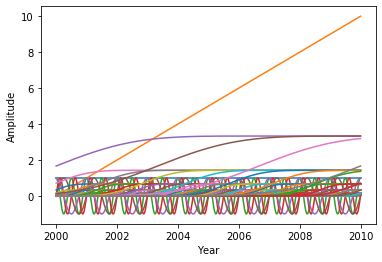

In [4]:
# First convert the time vector to a list of datetime
dates = ice.tdec2datestr(t, returndate=True)

# Build the collection
collection = build_collection(dates)

# Instantiate a model
model = ice.tseries.Model(dates, collection=collection)

# Access the design matrix for plotting
G = model.G
plt.plot(t, G)
plt.xlabel('Year')
plt.ylabel('Amplitude')
plt.show()

Let's explore the time series model and design matrix a bit. Currently, `iceutils` defines four different categories of signals:

1. secular - polynomial terms
2. seasonal - repeating seasonal signals (sinusoidal or spline-based)
3. step - Heaviside step functions for earthquakes, jumps, offsets, etc.
4. transient - non-permanent, one-sided signals

The column indices for the four different categories of signals are handled by `iceutils.tseries.Model` and stored in object attributes as `isecular`, `iseasonal`, `istep`, and `itransient`, respectively.

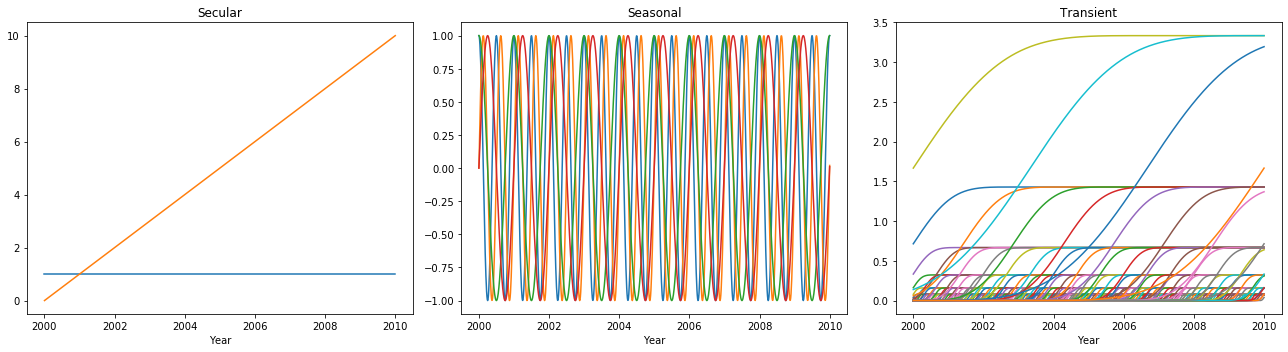

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,5))

ax1.plot(t, G[:, model.isecular])
ax2.plot(t, G[:, model.iseasonal])
ax3.plot(t, G[:, model.itransient])

ax1.set_title('Secular')
ax2.set_title('Seasonal')
ax3.set_title('Transient')
for ax in (ax1, ax2, ax3):
    ax.set_xlabel('Year')

plt.tight_layout()
plt.show()

Now we are ready to perform a linear regression for the coefficients of the matrix `G`. Note that in the above plot, we have a lot of different basis functions which are not orthogonal to each other. Therefore, `G` will generally be ill-conditioned for linear regression, and we'll need to add some type of regularization on the coefficients. In `iceutils`, we have support for L2-norm regularization (ridge regression) or L1-norm regularization (lasso regression). Let's first try ridge regression:

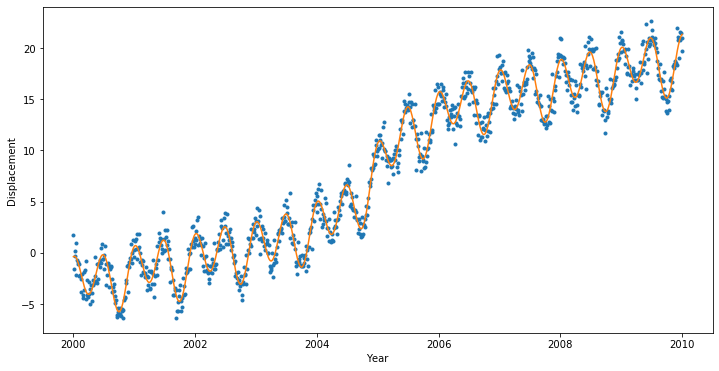

In [6]:
# Create a ridge regression solver that damps out the transient spline coefficients
ridge = ice.tseries.select_solver('ridge', reg_indices=model.itransient, penalty=0.1)

# Perform inversion to get coefficient vector and coefficient covariance matrix
m, Cm = ridge.invert(model.G, d)

# Model will perform predictions
pred = model.predict(m)

# Plotting
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t, d, '.')
ax.plot(t, pred['full'])
ax.set_xlabel('Year')
ax.set_ylabel('Displacement')
plt.show()

The linear regression appears to have fit the dataset fairly well. Let's look at how the model has discriminated between long-term signals (secular + transient) and short-term seasonal signals.

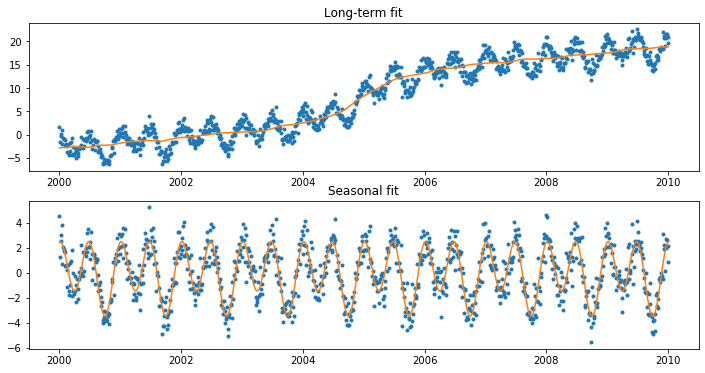

In [7]:
# Detrend the long-term signals from the data
fit_long = pred['secular'] + pred['transient']
d_short = d - fit_long

# Plotting
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,6))

ax1.plot(t, d, '.')
ax1.plot(t, fit_long)
ax1.set_title('Long-term fit')

ax2.plot(t, d_short, '.')
ax2.plot(t, pred['seasonal'])
ax2.set_title('Seasonal fit')
plt.show()

At first glance, the decomposition looks pretty good. If all we cared about was separting out the short- and long-term signals, then we can stop here. For some applications, we further want to properly separate out the transient signals from the overall long-term signals. Let's see how well we did for that task:

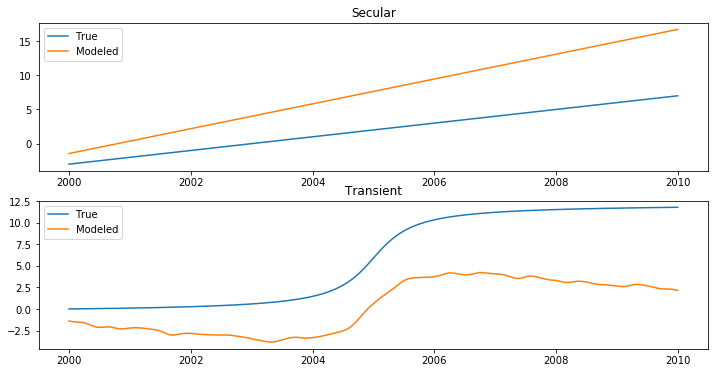

In [8]:
# Plotting modeled vs. true secular and transient signals
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,6))

ax1.plot(t, d_secular, label='True')
ax1.plot(t, pred['secular'], label='Modeled')
ax1.set_title('Secular')
leg1 = ax1.legend(loc='best')

ax2.plot(t, d_transient, label='True')
ax2.plot(t, pred['transient'], label='Modeled')
ax2.set_title('Transient')
leg2 = ax2.legend(loc='best')

plt.show()

We can see that we've encountered a common issue in these types of regression problems, mainly tradeoffs between different basis functions in the design matrix. In this case, there is "leakage" between the secular and transient signals, and we get errors in the reconstruction of both. One knob we could potentially tune is the penalty parameter provided to the ridge regression solver.

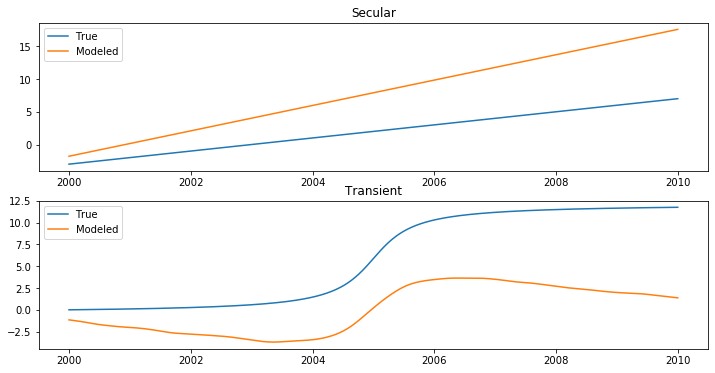

In [9]:
# Create another ridge regression solver with a larger penalty parameter
ridge = ice.tseries.select_solver('ridge', reg_indices=model.itransient, penalty=2)
# Re-do inversion and prediction
m, Cm = ridge.invert(model.G, d)
pred = model.predict(m)

# Plotting modeled vs. true secular and transient signals
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,6))

ax1.plot(t, d_secular, label='True')
ax1.plot(t, pred['secular'], label='Modeled')
ax1.set_title('Secular')
leg1 = ax1.legend(loc='best')

ax2.plot(t, d_transient, label='True')
ax2.plot(t, pred['transient'], label='Modeled')
ax2.set_title('Transient')
leg2 = ax2.legend(loc='best')

plt.show()

Unfortunately, increasing the penalty parameter only resulted in a smoother transient model without improving the leakage of the secular component into the transient. Let's now try using the lasso regression solver:

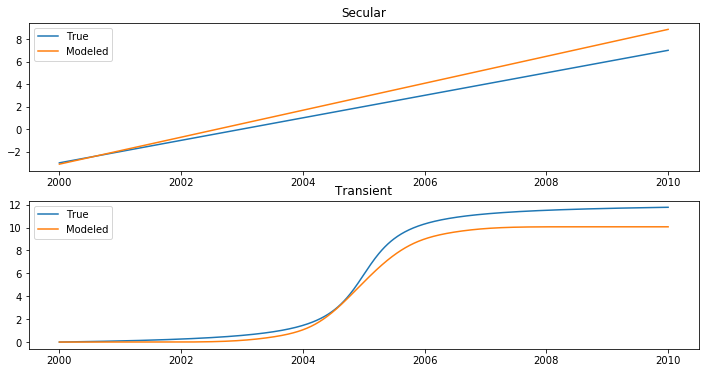

In [10]:
# Create lasso regression object
lasso = ice.tseries.select_solver('lasso', reg_indices=model.itransient, penalty=20)
# Re-do inversion and prediction
m_lasso, Cm = lasso.invert(model.G, d)
pred = model.predict(m_lasso)

# Plotting modeled vs. true secular and transient signals
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,6))

ax1.plot(t, d_secular, label='True')
ax1.plot(t, pred['secular'], label='Modeled')
ax1.set_title('Secular')
leg1 = ax1.legend(loc='best')

ax2.plot(t, d_transient, label='True')
ax2.plot(t, pred['transient'], label='Modeled')
ax2.set_title('Transient')
leg2 = ax2.legend(loc='best')

plt.show()

The lasso regression solver has done a much better job at recreating the one-sided displacment of the transient function while also recreating the secular signal reasonably well. We can view the estimated basis function coefficients for the different solvers:

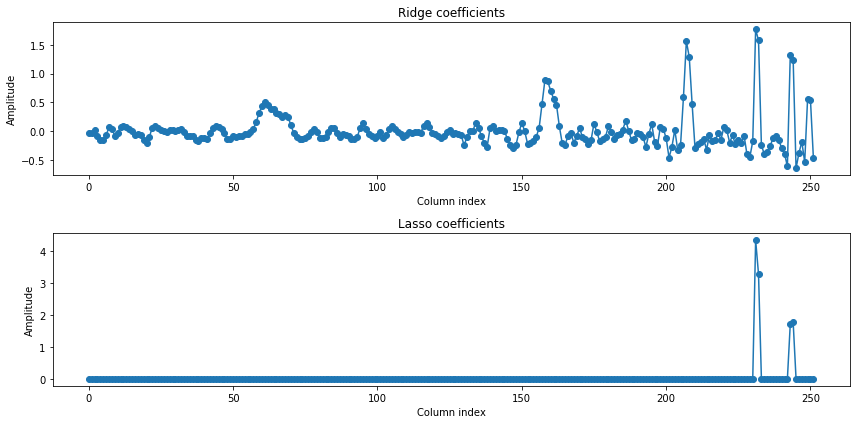

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,6))

ax1.plot(m[model.itransient], '-o')
ax2.plot(m_lasso[model.itransient], '-o')

for ax in (ax1, ax2):
    ax.set_xlabel('Column index')
    ax.set_ylabel('Amplitude')
ax1.set_title('Ridge coefficients')
ax2.set_title('Lasso coefficients')

plt.tight_layout()
plt.show()

In the above plot, we can see that the lasso solver has resulted in a sparse coefficient vector with only 4 non-zero elements corresponding to the longer-timescale transient basis functions. On the other hand, the ridge solver coefficient vector is fully dense. This result illustrates the difference between the L2- and L1-norm regularization approaches. In addition to obtaining a sparser and more interpretable coefficient vector, L1-norm regularization can also lead to better reconstruction of secular and transient signals.